In [ ]:
#| default_exp garch

In [ ]:
#| hide
import warnings
warnings.simplefilter('ignore')

# GARCH 

In [ ]:
#| export
import os 
import numpy as np
from numba import njit
from scipy.optimize import minimize

In [ ]:
#| export 
NOGIL = os.environ.get('NUMBA_RELEASE_GIL', 'False').lower() in ['true']
CACHE = os.environ.get('NUMBA_CACHE', 'False').lower() in ['true']

In [ ]:
#| hide 
import matplotlib.pyplot as plt

## Generate GARCH data 

In [ ]:
#| exporti
@njit(nogil=NOGIL, cache=CACHE)
def generate_garch_data(n, w, alpha, beta): 
    
    np.random.seed(1)
    
    y = np.zeros(n) 
    sigma2 = np.zeros(n)
    
    p = len(alpha)
    q = len(beta)
    
    w_vals = w < 0 
    alpha_vals = np.any(alpha < 0) 
    beta_vals = np.any(beta < 0) 
    
    if np.any(np.array([w_vals, alpha_vals, beta_vals])): 
        raise ValueError('Coefficients must be nonnegative')
    
    if np.sum(alpha)+np.sum(beta) >= 1:  
        raise ValueError('Sum of coefficients of lagged versions of the series and lagged versions of volatility must be less than 1')
    
    # initialization
    if q != 0: 
        sigma2[0:q] = 1
    
    for k in range(p): 
        y[k] = np.random.normal(loc = 0, scale = 1) 

    for k in range(max(p,q),n): 
        psum = np.flip(alpha)*(y[k-p:k]**2)
        psum = np.nansum(psum)
        if q != 0: 
            qsum = np.flip(beta)*(sigma2[k-q:k])
            qsum = np.nansum(qsum) 
            sigma2[k] = w+psum+qsum
        else: 
            sigma2[k] = w+psum
        y[k] = np.random.normal(loc = 0, scale = np.sqrt(sigma2[k])) 

    return y

[<matplotlib.lines.Line2D>]

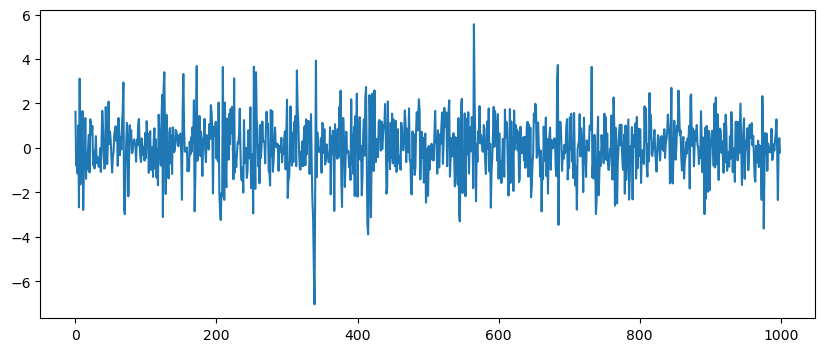

In [ ]:
#| hide 
# GARCH(1,1) 
n = 1000 
w = 0.5 
alpha = np.array([0.3])
beta = np.array([0.4])

y = generate_garch_data(n, w, alpha, beta) 

plt.figure(figsize=(10,4))
plt.plot(y)

In [ ]:
#| hide 
# Coefficients from arch library 
np.array([0.4307, 0.3050, 0.4243])

array([0.4307, 0.305 , 0.4243])

## Generate GARCH(p,q) model 

[<matplotlib.lines.Line2D>]

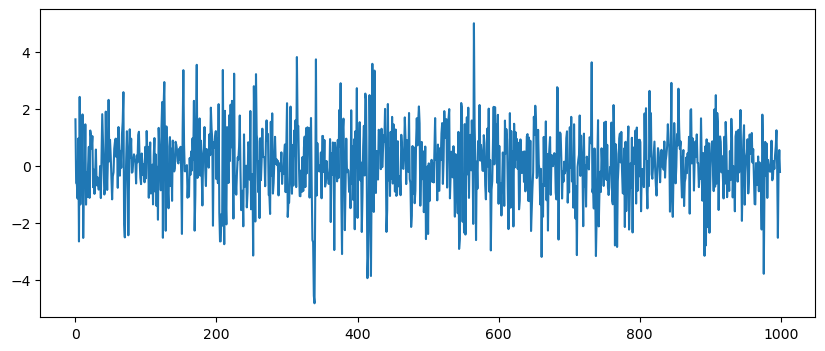

In [ ]:
#| hide 
# GARCH(2,2) 
n = 1000 
w = 0.5
alpha = np.array([0.1, 0.2])
beta = np.array([0.3, 0.1])

y = generate_garch_data(n, w, alpha, beta) 

plt.figure(figsize=(10,4))
plt.plot(y)

In [ ]:
#| exporti
@njit(nogil=NOGIL, cache=CACHE)
def garch_sigma2(x0, x, p, q): 
    
    w = x0[0] 
    alpha = x0[1:(p+1)]
    beta = x0[(p+1):]
    
    sigma2 = np.full((len(x), ), np.nan) 
    sigma2[0] = np.var(x) # sigma2 can be initialized with the unconditional variance

    for k in range(max(p,q), len(x)): 
        psum = np.flip(alpha)*(x[k-p:k]**2)
        psum = np.nansum(psum)
        if q != 0: 
            qsum = np.flip(beta)*(sigma2[k-q:k])
            qsum = np.nansum(qsum) 
            sigma2[k] = w+psum+qsum
        else: 
            sigma2[k] = w+psum
    
    return sigma2 

In [ ]:
#| hide 
x0 = np.array([0.5, 0.1, 0.2, 0.3, 0.1])
p = 2
q = 2 

sigma2 = garch_sigma2(x0, y, p, q)

In [ ]:
#| exporti
@njit(nogil=NOGIL, cache=CACHE)
def garch_cons(x0):    
    # Constraints for GARCH model
    # alpha+beta < 1 
    return 1-(x0[1:].sum())

In [ ]:
#| hide 
garch_cons(x0)

0.29999999999999993

In [ ]:
#| exporti 
@njit(nogil=NOGIL, cache=CACHE)
def garch_loglik(x0, x, p, q): 
    
    sigma2 = garch_sigma2(x0, x, p, q)
    z = x-np.nanmean(x)
    loglik = 0 
    
    for k in range(max(p,q), len(z)): 
        if sigma2[k] == 0: 
            sigma2[k] = 1e-10
        loglik = loglik - 0.5*(np.log(2*np.pi) + np.log(sigma2[k]) + (z[k]**2)/sigma2[k])
    
    return -loglik

In [ ]:
#| hide
garch_loglik(x0, y, p, q) 

1591.9510014484165

In [ ]:
#| exporti 
def garch_model(x, p, q): 
    
    np.random.seed(1)
    x0 = np.repeat(0.1, p+q+1)
    bnds = ((0, None), )*len(x0)
    cons = ({'type': 'ineq', 'fun': garch_cons})
    opt = minimize(garch_loglik, x0, args = (x, p, q), method = 'SLSQP', bounds = bnds, constraints = cons)
    
    coeff = opt.x 
    sigma2 = garch_sigma2(coeff, x, p, q)
    fitted = np.full((len(x), ), np.nan)
    
    for k in range(p,len(x)): 
        error = np.random.normal(loc = 0, scale = 1) 
        fitted[k] = error*np.sqrt(sigma2[k])
    
    res = {'p': p, 'q': q, 'coeff': coeff, 'message': opt.message, 'y_vals': x[-p:], 'sigma2_vals': sigma2[-q:], 'fitted': fitted}
    
    return res 

In [ ]:
#| hide
mod = garch_model(y, p, q)

In [ ]:
#| hide 
np.around(mod['coeff'], 5)

array([0.52284, 0.09169, 0.30457, 0.28889, 0.     ])

In [ ]:
#| hide 
# Coefficients from arch library 
np.array([0.5300, 0.0920, 0.3039, 0.2856, 2.7330e-15])

array([5.300e-01, 9.200e-02, 3.039e-01, 2.856e-01, 2.733e-15])

In [ ]:
#| exporti 
def garch_forecast(mod, h): 
    
    np.random.seed(1)
    
    p = mod['p']
    q = mod['q']
    
    w = mod['coeff'][0]
    alpha = mod['coeff'][1:(p+1)]
    beta = mod['coeff'][(p+1):]

    y_vals = np.full((h+p, ), np.nan) 
    sigma2_vals = np.full((h+q, ), np.nan) 

    y_vals[0:p] = mod['y_vals']
    
    if q!= 0: 
        sigma2_vals[0:q] = mod['sigma2_vals']
    
    for k in range(0, h): 
        error = np.random.normal(loc = 0, scale = 1) 
        psum = np.flip(alpha)*(y_vals[k:p+k]**2)
        psum = np.nansum(psum)
        if q != 0: 
            qsum = np.flip(beta)*(sigma2_vals[k:q+k])
            qsum = np.nansum(qsum) 
            sigma2hat = w+psum+qsum
        else: 
            sigma2hat = w+psum
        yhat = error*np.sqrt(sigma2hat)
        y_vals[p+k] = yhat 
        sigma2_vals[q+k] = sigma2hat 
    
    res = {'mean': y_vals[-h:], 'sigma2': sigma2_vals[-h:], 'fitted': mod['fitted']}
    
    return res 

In [ ]:
#| hide 
h = 50
fcst = garch_forecast(mod, h)

<matplotlib.legend.Legend>

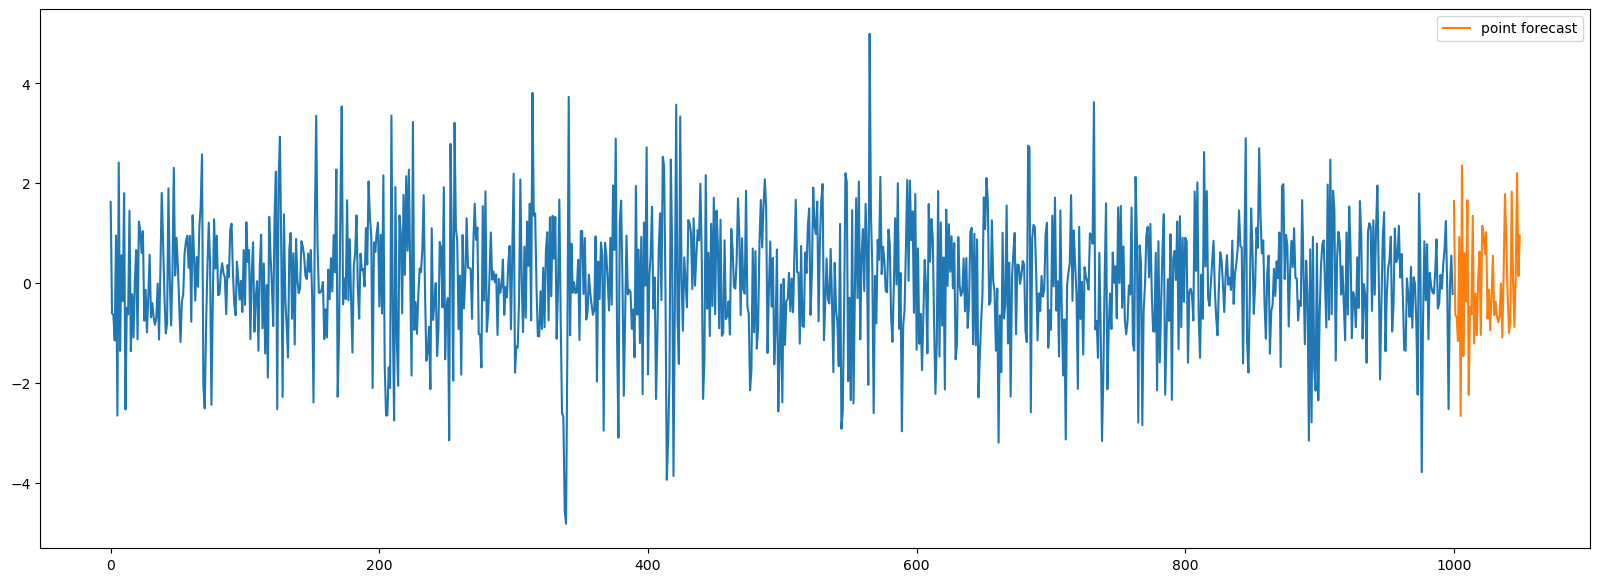

In [ ]:
#| hide 
fig, ax = plt.subplots(1, 1, figsize = (20,7))
plt.plot(np.arange(0, len(y)), y) 
plt.plot(np.arange(len(y), len(y) + h), fcst['mean'], label='point forecast')
plt.legend()

<matplotlib.legend.Legend>

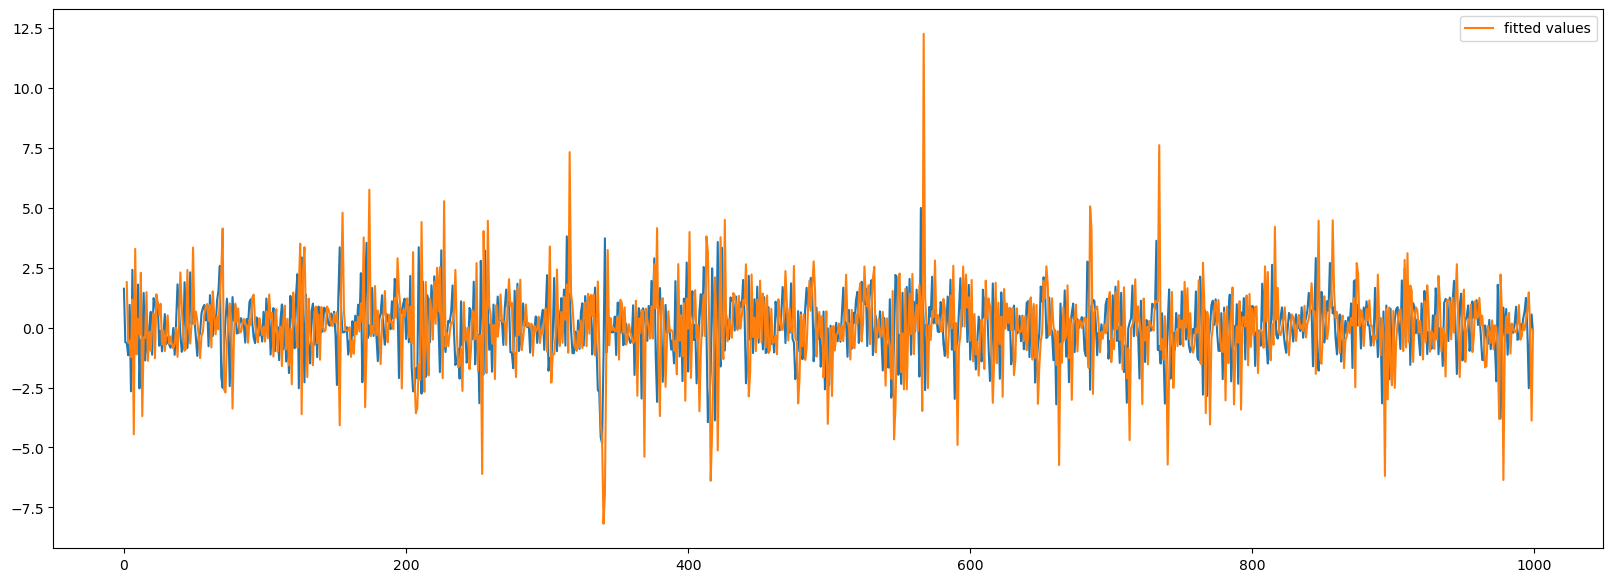

In [ ]:
#| hide 
fig, ax = plt.subplots(1, 1, figsize = (20,7))
plt.plot(np.arange(0, len(y)), y) 
plt.plot(np.arange(0, len(y)), fcst['fitted'], label='fitted values') 
plt.legend()

### Comparison with arch library

This section compares the coefficients generated by the previous functions with the coefficients generated by the [arch library](https://github.com/bashtage/arch) for $p=q$, $p>q$, $p<q$, and $q=0$. 

In [ ]:
#| hide
# p = q 
mod = garch_model(y, 1, 1) 
print('StatsForecast\'s coefficients: ') 
print(np.around(mod['coeff'], 5))
print('')
print('arch\'s coefficients: ') 
print(np.array([0.3238, 0.1929, 0.6016]))

StatsForecast's coefficients: 
[0.32047 0.19484 0.60194]

arch's coefficients: 
[0.3238 0.1929 0.6016]


In [ ]:
#| hide
# p > q 
mod = garch_model(y, 2, 1) 
print('StatsForecast\'s coefficients: ') 
print(np.around(mod['coeff'], 5))
print('')
print('arch\'s coefficients: ') 
print(np.array([0.5299, 0.0920, 0.3039, 0.2846])) 

StatsForecast's coefficients: 
[0.52288 0.09171 0.30456 0.28883]

arch's coefficients: 
[0.5299 0.092  0.3039 0.2846]


In [ ]:
#| hide 
# p < q 
mod = garch_model(y, 1, 2) 
print('StatsForecast\'s coefficients: ') 
print(np.around(mod['coeff'], 5))
print('') 
print('arch\'s coefficients: ') 
print(np.array([0.3238, 0.1930, 0.6015, 9.2320e-13]))

StatsForecast's coefficients: 
[0.34094 0.20019 0.58494 0.     ]

arch's coefficients: 
[3.238e-01 1.930e-01 6.015e-01 9.232e-13]


In [ ]:
#| hide 
# q = 0 
mod = garch_model(y, 1, 0) 
print('StatsForecast\'s coefficients: ') 
print(np.around(mod['coeff'], 5))
print('') 
print('arch\'s coefficients: ') 
print(np.array([1.3503, 0.1227]))

StatsForecast's coefficients: 
[1.3514  0.12147]

arch's coefficients: 
[1.3503 0.1227]
